 --- 
# UCI - Default from Credit Card Clients
---

# Dataset presentation

This dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005.

It can be found here:
https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

## Variables
There are 25 variables:

* ID: ID of each client
* LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit
* SEX: Gender (1=male, 2=female)
* EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
* MARRIAGE: Marital status (1=married, 2=single, 3=others)
* AGE: Age in years
* PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above)
* PAY_2: Repayment status in August, 2005 (scale same as above)
* PAY_3: Repayment status in July, 2005 (scale same as above)
* PAY_4: Repayment status in June, 2005 (scale same as above)
* PAY_5: Repayment status in May, 2005 (scale same as above)
* PAY_6: Repayment status in April, 2005 (scale same as above)
* BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)
* BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)
* BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)
* BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)
* BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)
* BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)
* PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)
* PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)
* PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)
* PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)
* PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)
* PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)
* default.payment.next.month: Default payment (1=yes, 0=no)


In [1]:
%load_ext autoreload
%autoreload 2

# Useful imports

## Packages

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
pd.set_option('display.max_columns', 120)

In [4]:
sns.set_style("darkgrid")

## Data Preparation imports

from sklearn.preprocessing import StandardScaler

## Model imports

In [97]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [6]:
import xgboost as xgb

In [7]:
import lightgbm as lgb

In [8]:
# import catboost

## Preproecssing imports

In [9]:
from sklearn.pipeline import Pipeline

## Metrics imports

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [96]:
import time

In [11]:
import os
os.environ['PATH'].split(';')

['C:\\Users\\twang\\AppData\\Local\\Continuum\\anaconda3',
 'C:\\Users\\twang\\AppData\\Local\\Continuum\\anaconda3\\Library\\mingw-w64\\bin',
 'C:\\Users\\twang\\AppData\\Local\\Continuum\\anaconda3\\Library\\usr\\bin',
 'C:\\Users\\twang\\AppData\\Local\\Continuum\\anaconda3\\Library\\bin',
 'C:\\Users\\twang\\AppData\\Local\\Continuum\\anaconda3\\Scripts',
 'C:\\Users\\twang\\AppData\\Local\\Continuum\\anaconda3\\bin',
 'C:\\Users\\twang\\AppData\\Local\\Continuum\\anaconda3\\condabin',
 'C:\\Program Files\\Docker\\Docker\\Resources\\bin',
 'C:\\ProgramData\\Oracle\\Java\\javapath',
 'C:\\WINDOWS\\system32',
 'C:\\WINDOWS',
 'C:\\WINDOWS\\System32\\Wbem',
 'C:\\WINDOWS\\System32\\WindowsPowerShell\\v1.0',
 'C:\\Program Files\\PuTTY',
 'C:\\Program Files\\Intel\\WiFi\\bin',
 'C:\\Program Files\\Common Files\\Intel\\WirelessCommon',
 'C:\\Program Files\\Git LFS',
 'C:\\Program Files\\Pandoc',
 'C:\\Program Files\\MiKTeX 2.9\\miktex\\bin\\x64',
 'C:\\Users\\twang\\AppData\\Local\\Conti

# Importing our Data easily!

In [12]:
path = 'UCI_Credit_Card.csv'

In [13]:
from dataprep.load import load_raw_data
from dataprep.load import load_data
from dataprep.load import load_data_xy


df = load_data(path)
X_raw, y_raw = load_data_xy(path)

# Defining our train/test sets

## Splitting our Df into test/train/val

In [14]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df, 
                                    test_size=6000, 
                                    stratify=df.default, 
                                    random_state=42)
df_train, df_test = train_test_split(df_train, 
                                     test_size=6000, 
                                     stratify=df_train.default, 
                                     random_state=42)

## Splitting into (X,y)

In [15]:
from dataprep.load import df2xy

X_train, y_train = df2xy(df_train, 'default')
X_test, y_test = df2xy(df_test, 'default')
X_val, y_val = df2xy(df_val, 'default')

# Protocol for pipelined workflow

Puis on se doit de définir les dictionnaires / classes que l'on va utiliser pour stocker les modèles, leurs scores selon toutes les métriques

Ainsi, on pourra les capitalizer facilement

# Elementary Pipelines

Elementary Pipelines are Pipelines that only do a little processing, such as adding / removing a single feature

## Elementary Transformers from Packages

In [16]:
from sklearn.preprocessing import StandardScaler

## Custom Transformers

In [17]:
# Gather data by age group
from dataprep.pipelines import AgeBinAdder
# Gender x Marriage new category
from dataprep.pipelines import GenderXMarriageAdder
# Gender x AgeBin new category
from dataprep.pipelines import GenderXAgeBinAdder
# Predict next month's bill statement
from dataprep.pipelines import NextBillAdder
# Get_dummies to Df
from dataprep.pipelines import CategoricalWarrior
# Drop a column
from dataprep.pipelines import ColumnDropper


# Prediction Classifiers

Let's define the different classifiers that we will be using

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier


In [19]:
dico_models = {}

In [20]:
dico_models['log'] = log_clf = LogisticRegression(C=0.1, 
                             solver='liblinear',
                             penalty='l2',
                             class_weight='balanced', 
                             random_state=42, 
                             n_jobs=-1)
dico_models['svm'] =  SVC(gamma='auto', C=1, class_weight='balanced')
dico_models['tree'] = DecisionTreeClassifier(criterion='entropy', 
                                  random_state=42, 
                                 max_leaf_nodes=5,
                                 class_weight='balanced')
dico_models['forest'] = RandomForestClassifier(n_estimators=500, 
                                 max_leaf_nodes=10, 
                                 n_jobs=-1, 
                                 class_weight='balanced',
                                random_state=42)

dico_models['adaboost'] = AdaBoostClassifier()

In [21]:
dico_models['xgboost'] = xgb.XGBClassifier(scale_pos_weight=5)

# Prediction Pipelines

Prediction Pipelines consists of the following architecture:  
  [Complex Pipeline, Classifier]

In [22]:
from collections import defaultdict

dico_pipelined_models_num = defaultdict(dict)
dico_pipelined_models_cat = defaultdict(dict)

## Defining which preprocessing pipelines we should use, for each model

In [23]:
from sklearn.pipeline import make_pipeline

In [24]:
dico_appropriate_preproc = defaultdict(list)

### Logistic Regression

In [25]:
dico_appropriate_preproc['log'] = []

dico_appropriate_preproc['log'].append( make_pipeline(StandardScaler()) )
dico_appropriate_preproc['log'].append( make_pipeline(NextBillAdder(), 
                                                      StandardScaler()) )
dico_appropriate_preproc['log'].append( make_pipeline(AgeBinAdder(), 
                                                      GenderXAgeBinAdder(), 
                                                      GenderXMarriageAdder(), 
                                                      NextBillAdder(), 
                                                      CategoricalWarrior(['gender', 'education', 'marriage']) ) )
dico_appropriate_preproc['log'].append( make_pipeline(AgeBinAdder(), 
                                                      GenderXAgeBinAdder(), 
                                                      GenderXMarriageAdder(), 
                                                      NextBillAdder(), 
                                                      CategoricalWarrior(['gender', 'education', 'marriage']),
                                                      StandardScaler()) )
dico_appropriate_preproc['log'].append( make_pipeline(AgeBinAdder(), 
                                                      GenderXAgeBinAdder(), 
                                                      GenderXMarriageAdder(), 
                                                      NextBillAdder(), 
                                                      ColumnDropper('age'), 
                                                      CategoricalWarrior(['gender', 'education', 'marriage']) ) ) 
dico_appropriate_preproc['log'].append( make_pipeline(AgeBinAdder(), 
                                                      GenderXAgeBinAdder(), 
                                                      GenderXMarriageAdder(), 
                                                      NextBillAdder(), 
                                                      ColumnDropper('age'), 
                                                      CategoricalWarrior(['gender', 'education', 'marriage']), 
                                                      StandardScaler()) )

### SVM

In [26]:
dico_appropriate_preproc['svm'] = []

dico_appropriate_preproc['svm'].append( make_pipeline(StandardScaler()) )
dico_appropriate_preproc['svm'].append( make_pipeline(NextBillAdder(), 
                                                      StandardScaler()) )
dico_appropriate_preproc['svm'].append( make_pipeline(AgeBinAdder(), 
                                                      GenderXAgeBinAdder(), 
                                                      GenderXMarriageAdder(), 
                                                      NextBillAdder(), 
                                                      ColumnDropper('age'), 
                                                      CategoricalWarrior(['gender', 'education', 'marriage']), 
                                                      StandardScaler()) )

### Decision Tree

In [27]:
dico_appropriate_preproc['tree'] = []

dico_appropriate_preproc['tree'].append( make_pipeline(StandardScaler()) )
dico_appropriate_preproc['tree'].append( make_pipeline(NextBillAdder(), 
                                                      StandardScaler()) )
dico_appropriate_preproc['tree'].append( make_pipeline(AgeBinAdder(), 
                                                      GenderXAgeBinAdder(), 
                                                      GenderXMarriageAdder(), 
                                                      NextBillAdder(), 
                                                      CategoricalWarrior(['gender', 'education', 'marriage']) ) )
dico_appropriate_preproc['tree'].append( make_pipeline(AgeBinAdder(), 
                                                      GenderXAgeBinAdder(), 
                                                      GenderXMarriageAdder(), 
                                                      NextBillAdder(), 
                                                      ColumnDropper('age'), 
                                                      CategoricalWarrior(['gender', 'education', 'marriage']) ) ) 
dico_appropriate_preproc['tree'].append( make_pipeline(AgeBinAdder(), 
                                                      GenderXAgeBinAdder(), 
                                                      GenderXMarriageAdder(), 
                                                      NextBillAdder(), 
                                                      ColumnDropper('age'), 
                                                      CategoricalWarrior(['gender', 'education', 'marriage']), 
                                                      StandardScaler()) )

### Random Forest

In [28]:
dico_appropriate_preproc['forest'] = []

dico_appropriate_preproc['forest'].append( make_pipeline(StandardScaler()) )
dico_appropriate_preproc['forest'].append( make_pipeline(NextBillAdder(), 
                                                      StandardScaler()) )
dico_appropriate_preproc['forest'].append( make_pipeline(AgeBinAdder(), 
                                                      GenderXAgeBinAdder(), 
                                                      GenderXMarriageAdder(), 
                                                      NextBillAdder(), 
                                                      CategoricalWarrior(['gender', 'education', 'marriage']) ) )
dico_appropriate_preproc['forest'].append( make_pipeline(AgeBinAdder(), 
                                                      GenderXAgeBinAdder(), 
                                                      GenderXMarriageAdder(), 
                                                      NextBillAdder(), 
                                                      ColumnDropper('age'), 
                                                      CategoricalWarrior(['gender', 'education', 'marriage']) ) ) 
dico_appropriate_preproc['forest'].append( make_pipeline(AgeBinAdder(), 
                                                      GenderXAgeBinAdder(), 
                                                      GenderXMarriageAdder(), 
                                                      NextBillAdder(), 
                                                      ColumnDropper('age'), 
                                                      CategoricalWarrior(['gender', 'education', 'marriage']), 
                                                      StandardScaler()) )

### Adaboost

It overfits the majority class 'default' too much, let's stop experimenting on it!

### XGBoost

In [29]:
dico_appropriate_preproc['xgboost'] = []

dico_appropriate_preproc['xgboost'].append( make_pipeline(StandardScaler()) )
dico_appropriate_preproc['xgboost'].append( make_pipeline(NextBillAdder(), 
                                                      StandardScaler()) )
dico_appropriate_preproc['xgboost'].append( make_pipeline(AgeBinAdder(), 
                                                      GenderXAgeBinAdder(), 
                                                      GenderXMarriageAdder(), 
                                                      NextBillAdder(), 
                                                      CategoricalWarrior(['gender', 'education', 'marriage']) ) )
dico_appropriate_preproc['xgboost'].append( make_pipeline(AgeBinAdder(), 
                                                      GenderXAgeBinAdder(), 
                                                      GenderXMarriageAdder(), 
                                                      NextBillAdder(), 
                                                      ColumnDropper('age'), 
                                                      CategoricalWarrior(['gender', 'education', 'marriage']) ) ) 
dico_appropriate_preproc['xgboost'].append( make_pipeline(AgeBinAdder(), 
                                                      GenderXAgeBinAdder(), 
                                                      GenderXMarriageAdder(), 
                                                      NextBillAdder(), 
                                                      ColumnDropper('age'), 
                                                      CategoricalWarrior(['gender', 'education', 'marriage']), 
                                                      StandardScaler()) )

### CatBoost

## Defining all the Prediction Pipelines to train

In [30]:
dico_pipelined_models_num = defaultdict(dict)

for (name, model) in dico_models.items():
#     print(name)
    for (i, complex_pipe) in enumerate(dico_appropriate_preproc[name]):
#         print(i)
        dico_pipelined_models_num[name][i] = Pipeline([
            ('preproc', complex_pipe),
            ('classifier', model)
        ])

In [31]:
dico_pipelined_models_num

defaultdict(dict, {'log': {0: Pipeline(memory=None,
                       steps=[('preproc',
                               Pipeline(memory=None,
                                        steps=[('standardscaler',
                                                StandardScaler(copy=True, with_mean=True,
                                                               with_std=True))],
                                        verbose=False)),
                              ('classifier',
                               LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                                                  fit_intercept=True, intercept_scaling=1,
                                                  l1_ratio=None, max_iter=100,
                                                  multi_class='warn', n_jobs=-1, penalty='l2',
                                                  random_state=42, solver='liblinear',
                                                  tol=0.0001, verbos

# Training

## Training all the Prediction Pipelines

In [32]:
dico_classification_reports = defaultdict(dict)
dico_confusion_matrices = defaultdict(dict)

In [33]:
for (name, model) in dico_models.items():
    print(name.upper())
    print('-------------')
    for (i, complex_pipe) in enumerate(dico_pipelined_models_num[name]):
#         print('!!! POURQUOI CA MARCHE PAS !!!')
        pipe = dico_pipelined_models_num[name][i]
        pipe.fit(X_train, np.ravel(y_train))
        print('Pipe {}, {}'.format(i, name.capitalize()))
        print('----------------')
        
        y_pred = pipe.predict(X_test)
        dico_classification_reports[name][i] = classification_report(y_test, y_pred)
        dico_confusion_matrices[name][i] = confusion_matrix(y_test, y_pred)
        print(dico_classification_reports[name][i])
        #print(dico_confusion_matrices[i][name])

#         print('!!! POURQUOI CA MARCHE PAS !!!')'

LOG
-------------


C:\Users\twang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Pipe 0, Log
----------------
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      4673
           1       0.48      0.57      0.52      1327

    accuracy                           0.77      6000
   macro avg       0.68      0.70      0.69      6000
weighted avg       0.78      0.77      0.78      6000



C:\Users\twang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Pipe 1, Log
----------------
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      4673
           1       0.48      0.57      0.52      1327

    accuracy                           0.77      6000
   macro avg       0.68      0.70      0.69      6000
weighted avg       0.78      0.77      0.78      6000



C:\Users\twang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Pipe 2, Log
----------------
              precision    recall  f1-score   support

           0       0.86      0.51      0.64      4673
           1       0.29      0.71      0.41      1327

    accuracy                           0.56      6000
   macro avg       0.58      0.61      0.53      6000
weighted avg       0.74      0.56      0.59      6000



C:\Users\twang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Pipe 3, Log
----------------
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      4673
           1       0.49      0.57      0.53      1327

    accuracy                           0.77      6000
   macro avg       0.68      0.70      0.69      6000
weighted avg       0.79      0.77      0.78      6000



C:\Users\twang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Pipe 4, Log
----------------
              precision    recall  f1-score   support

           0       0.81      0.78      0.80      4673
           1       0.33      0.37      0.34      1327

    accuracy                           0.69      6000
   macro avg       0.57      0.58      0.57      6000
weighted avg       0.71      0.69      0.70      6000



C:\Users\twang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Pipe 5, Log
----------------
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      4673
           1       0.49      0.57      0.53      1327

    accuracy                           0.77      6000
   macro avg       0.68      0.70      0.69      6000
weighted avg       0.79      0.77      0.78      6000

SVM
-------------
Pipe 0, Svm
----------------
              precision    recall  f1-score   support

           0       0.87      0.80      0.84      4673
           1       0.46      0.59      0.52      1327

    accuracy                           0.76      6000
   macro avg       0.67      0.70      0.68      6000
weighted avg       0.78      0.76      0.77      6000

Pipe 1, Svm
----------------
              precision    recall  f1-score   support

           0       0.87      0.80      0.84      4673
           1       0.46      0.59      0.52      1327

    accuracy                           0.76      6000
   macro avg       0.67

## Our takeaways

### Per model

* Logistic regression:  
We have a great recall of our default class, using all our engineered features, as well as keeping our 'age' feature

* SVM:  
Adding our previously engineered features leads to no change

* Decision Tree:  
All the different preprocessing pipelines lead to similar results

* Random Forest:  
All the different preprocessing pipelines lead to similar results

* XGBoost:  
All the different preprocessing pipelines lead to similar results

In conclusion, it seems that all our new features aren't too useful, excepted for the Logistic Regression model

### Ranked by performance on test set

Let's have a look at the best (preprocessing, model) couples:   
(best = best recall score on the default class, evaluated on the Test set)

In [34]:
def show_classification_report(model_name, pipe_number):
    print('{}, Pipe {}'.format(model_name.capitalize(), pipe_number))
    print('----------------')
    print(dico_classification_reports[model_name][pipe_number])
    print('------------------------------------------------------')

In [60]:
show_classification_report('log', 2)
show_classification_report('svm', 0)
show_classification_report('forest', 3)
show_classification_report('xgboost', 0)

Log, Pipe 2
----------------
              precision    recall  f1-score   support

           0       0.86      0.51      0.64      4673
           1       0.29      0.71      0.41      1327

    accuracy                           0.56      6000
   macro avg       0.58      0.61      0.53      6000
weighted avg       0.74      0.56      0.59      6000

------------------------------------------------------
Svm, Pipe 0
----------------
              precision    recall  f1-score   support

           0       0.87      0.80      0.84      4673
           1       0.46      0.59      0.52      1327

    accuracy                           0.76      6000
   macro avg       0.67      0.70      0.68      6000
weighted avg       0.78      0.76      0.77      6000

------------------------------------------------------
Forest, Pipe 3
----------------
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      4673
           1       0.46      0.62    

Meilleurs modèles (en comparant selon le recall des default):
* (XGBoost, 1): avec la prédiction du Next Bill
* (Logistic Regression, 2):, avec toutes les features engineerées et sans Scaling (!)
* (Random Forest, 3): (peu importe le type de preprocessing
* (SVM, 0): (scalé absolument, avec ou sans Next Bill ^^ )

## Feature importances

### Logistic Regression

In [45]:
dico_pipelined_models_num['log'][2].steps[0][1].transform(X_train).head()

,limit_bal,age,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,pred_bill_amt0,gender_2,gender_1,education_3,education_2,education_1,education_4,marriage_1,marriage_2,marriage_3,age_bin_20s,age_bin_30s,age_bin_40s,age_bin_50s,age_bin_60+,"gen_ageBin_(1, '20s')","gen_ageBin_(1, '30s')","gen_ageBin_(1, '40s')","gen_ageBin_(1, '50s')","gen_ageBin_(1, '60+')","gen_ageBin_(2, '20s')","gen_ageBin_(2, '30s')","gen_ageBin_(2, '40s')","gen_ageBin_(2, '50s')","gen_ageBin_(2, '60+')","gen_mar_(1, 1)","gen_mar_(1, 2)","gen_mar_(1, 3)","gen_mar_(2, 1)","gen_mar_(2, 2)","gen_mar_(2, 3)"
10574,20000.0,51,0,0,0,0,0,0,19255.0,20650.0,0.0,0.0,0.0,0.0,2000.0,0.0,0.0,0.0,0.0,0.0,19269.757474,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
11330,300000.0,31,0,0,0,0,0,0,285038.0,291480.0,298378.0,131103.0,128742.0,124882.0,12507.0,15056.0,5027.0,5007.0,5063.0,3039.0,285123.402526,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
7127,500000.0,40,0,0,0,0,0,0,33179.0,97882.0,48017.0,49403.0,40018.0,54109.0,99159.0,48276.0,49450.0,201.0,54379.0,9905.0,34020.039927,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
25150,70000.0,46,0,0,0,0,0,0,70349.0,70068.0,71318.0,59665.0,29510.0,26738.0,2600.0,3700.0,2600.0,1200.0,1200.0,1000.0,70345.498357,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
6000,50000.0,33,0,0,0,0,0,0,13538.0,9199.0,6879.0,6753.0,5440.0,5440.0,2000.0,1284.0,264.0,109.0,390.0,0.0,13480.622867,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [46]:
colonnes = list(dico_pipelined_models_num['log'][2].steps[0][1].transform(X_train).head().columns)

In [47]:
best_log_reg = dico_pipelined_models_num['log'][2].steps[1][1]

In [48]:
coefs=np.array(best_log_reg.coef_[0])
abs_coefs = np.abs(coefs)

In [49]:
feature_importances_log = pd.DataFrame(list(zip(colonnes, coefs, abs_coefs)),
                                  columns=['Feature', 'Coef', 'Abs Coef'])

In [50]:
feature_importances_log.sort_values(by=['Abs Coef'], ascending=False)

,Feature,Coef,Abs Coef
1,age,1.483173e-02,1.483173e-02
2,pay_1,1.320615e-02,1.320615e-02
3,pay_2,9.310837e-03,9.310837e-03
4,pay_3,7.725585e-03,7.725585e-03
5,pay_4,6.644211e-03,6.644211e-03
6,pay_5,5.950918e-03,5.950918e-03
7,pay_6,5.495529e-03,5.495529e-03
22,gender_1,1.670037e-03,1.670037e-03
30,age_bin_20s,1.450207e-03,1.450207e-03
24,education_2,1.283708e-03,1.283708e-03


### XGBoost

In [61]:
best_xgboost = dico_pipelined_models_num['xgboost'][0].steps[1][1]

In [80]:
def my_plot_importance(booster, figsize, fontsize, **kwargs): 
    from matplotlib import pyplot as plt
    from xgboost import plot_importance
    fig, ax = plt.subplots(1,1,figsize=figsize)
    plt.rc({'font.size': fontsize})
    return plot_importance(booster=booster, ax=ax, **kwargs)

In [81]:
colonnes_xgb = list(X_train.columns)

In [82]:
best_xgboost.get_booster().feature_names = colonnes_xgb

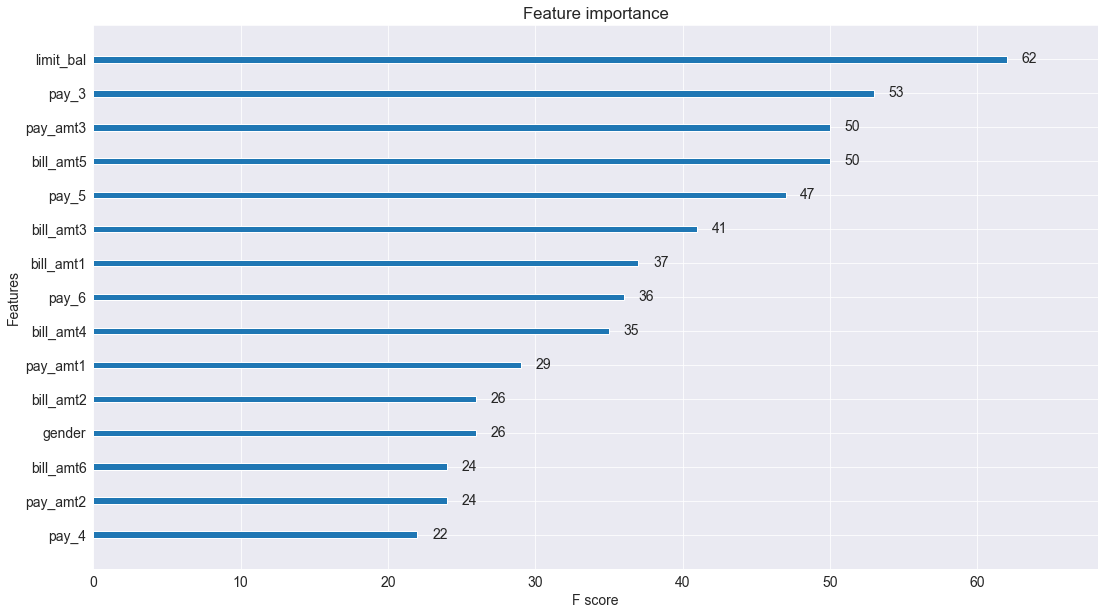

In [83]:
my_plot_importance(best_xgboost, (18,10), 14, max_num_features=15)

# Fine-tuning our best models

## Logistic Regression

In [89]:
best_log_pipe = dico_pipelined_models_num['log'][2]

In [91]:
best_log_pipe.get_params()

{'memory': None, 'steps': [('preproc', Pipeline(memory=None,
            steps=[('agebinadder', AgeBinAdder()),
                   ('genderxagebinadder', GenderXAgeBinAdder()),
                   ('genderxmarriageadder', GenderXMarriageAdder()),
                   ('nextbilladder', NextBillAdder()),
                   ('categoricalwarrior',
                    CategoricalWarrior(attribute_names=['gender', 'education',
                                                        'marriage']))],
            verbose=False)),
  ('classifier', LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                      fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                      max_iter=100, multi_class='warn', n_jobs=-1, penalty='l2',
                      random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                      warm_start=False))], 'verbose': False, 'preproc': Pipeline(memory=None,
          steps=[('agebinadder', AgeBinAdder()),
             

In [168]:
grid_params_log = {
    'classifier__C': np.logspace(-3, 2, num=200),
    'classifier__class_weight': ['balanced', {1: 6}, {1: 8}, {1: 10}, {1: 15}, {1: 20}],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__random_state': [42],
}

Defining our own custom loss function

In [169]:
from sklearn.metrics import make_scorer
recall_default_scorer = make_scorer(recall_score, average='binary', pos_label=1)

In [170]:
random_search_log = RandomizedSearchCV(estimator=best_log_pipe, 
                                       param_distributions=grid_params_log,
                                       n_iter=400,
                                       cv=3,
                                       scoring='recall_weighted'
                                      )

Calculating our default recall_weighted score, to know if our random search performs better or not

In [171]:
recall_score(y_test, best_log_pipe.predict(X_test), average='binary', pos_label=1)

0.707611152976639

In [172]:
t0 = time.time()
random_search_log.fit(X_train, np.ravel(y_train))
t1 = time.time()
print('Time: {:.2f}s'.format(t1-t0))

C:\Users\twang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\twang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\twang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\twang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  

Time: 3107.66s


In [173]:
random_search_log.best_params_

{'classifier__random_state': 42,
 'classifier__penalty': 'l1',
 'classifier__class_weight': 'balanced',
 'classifier__C': 0.015167168884709233}

In [174]:
random_search_log.best_score_

0.7714444444444445

In [175]:
recall_score(y_test, random_search_log.best_estimator_.predict(X_test), average='binary', pos_label=1)

0.5636774679728711

In [176]:
print(classification_report(y_test, random_search_log.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85      4673
           1       0.48      0.56      0.52      1327

    accuracy                           0.77      6000
   macro avg       0.68      0.70      0.68      6000
weighted avg       0.78      0.77      0.78      6000



In [177]:
print(confusion_matrix(y_test, random_search_log.best_estimator_.predict(X_test)))

[[3874  799]
 [ 579  748]]


## XGBoost

In [183]:
best_xgb_pipe = dico_pipelined_models_num['xgboost'][0]

In [184]:
best_xgb_pipe.get_params()

{'memory': None, 'steps': [('preproc', Pipeline(memory=None,
            steps=[('standardscaler',
                    StandardScaler(copy=True, with_mean=True, with_std=True))],
            verbose=False)),
  ('classifier',
   XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                 colsample_bynode=1, colsample_bytree=1, gamma=0,
                 learning_rate=0.1, max_delta_step=0, max_depth=3,
                 min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
                 nthread=None, objective='binary:logistic', random_state=0,
                 reg_alpha=0, reg_lambda=1, scale_pos_weight=5, seed=None,
                 silent=None, subsample=1, verbosity=1))], 'verbose': False, 'preproc': Pipeline(memory=None,
          steps=[('standardscaler',
                  StandardScaler(copy=True, with_mean=True, with_std=True))],
          verbose=False), 'classifier': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       

In [185]:
import scipy as sp

In [186]:
grid_params_xgb = {
    'classifier__max_depth': sp.stats.randint(1,10),
    'classifier__learning_rate': sp.stats.uniform(loc=0.05, scale=0.3),
    'classifier__n_estimators': sp.stats.randint(20,200),
    'classifier__scale_pos_weight': sp.stats.randint(4, 20),
    'classifier__reg_alpha': sp.stats.uniform(loc=0.01, scale=10),
    'classifier__reg_lambda': sp.stats.uniform(loc=0.01, scale=10),
    'classifier__random_state': [42]
}

In [218]:
random_search_xgb = RandomizedSearchCV(estimator=best_xgb_pipe, 
                                       param_distributions=grid_params_xgb,
                                       n_iter=100,
                                       cv=3,
                                       scoring='recall_weighted'
                                      )

Calculating our default recall_weighted score, to know if our random search performs better or not

In [219]:
best_xgboost.get_booster().feature_names = ['f{}'.format(i) for i in range(23)]

In [220]:
best_xgboost.get_booster().feature_names

['f0',
 'f1',
 'f2',
 'f3',
 'f4',
 'f5',
 'f6',
 'f7',
 'f8',
 'f9',
 'f10',
 'f11',
 'f12',
 'f13',
 'f14',
 'f15',
 'f16',
 'f17',
 'f18',
 'f19',
 'f20',
 'f21',
 'f22']

In [221]:
recall_score(y_test, best_xgb_pipe.predict(X_test), average='binary', pos_label=1)

0.8063300678221552

In [222]:
t0 = time.time()
random_search_xgb.fit(X_train, np.ravel(y_train))
t1 = time.time()
print('Time: {:.2f}s'.format(t1-t0))

Time: 1405.94s


In [223]:
random_search_xgb.best_params_

{'classifier__learning_rate': 0.2112670984507552,
 'classifier__max_depth': 9,
 'classifier__n_estimators': 120,
 'classifier__random_state': 42,
 'classifier__reg_alpha': 0.17072742888477266,
 'classifier__reg_lambda': 0.1443680569066974,
 'classifier__scale_pos_weight': 4}

In [224]:
random_search_xgb.best_score_

0.7808333333333334

In [225]:
recall_score(y_test, random_search_xgb.best_estimator_.predict(X_test), average='binary', pos_label=1)

0.47852298417483047

In [226]:
print(classification_report(y_test, random_search_xgb.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86      4673
           1       0.50      0.48      0.49      1327

    accuracy                           0.78      6000
   macro avg       0.68      0.67      0.68      6000
weighted avg       0.78      0.78      0.78      6000



In [227]:
print(confusion_matrix(y_test, random_search_xgb.best_estimator_.predict(X_test)))

[[4046  627]
 [ 692  635]]


In [228]:
best_xgboost.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 5,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

# TO DO Next